# Text transfer learning
*How to fine-tune a language model and train a classifier*

In [2]:
from fastai.text.all import *

ModuleNotFoundError: No module named 'fastai'

In this tutorial, we will see how we can train a model to classify text (here based on their sentiment). First we will see how to do this quickly in a few lines of code, then how to get state-of-the art results using the approach of the __[ULMFit paper](https://arxiv.org/abs/1801.06146)__.

We will use the IMDb dataset from the paper __[Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/data/sentiment/)__, containing a few thousand movie reviews.

## Train a text classifier from a pretrained model
We will try to train a classifier using a pretrained model, a bit like we do in the __[vision tutorial](https://docs.fast.ai/tutorial.vision.html)__. To get our data ready, we will first use the high-level API:

## Using the high-level API
We can download the data and decompress it with the following command:

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

In [ ]:
(path/'train').ls()

The data follows an ImageNet-style organization, in the train folder, we have two subfolders, pos and neg (for positive reviews and negative reviews). We can gather it by using the __[TextDataLoaders.from_folder](https://docs.fast.ai/text.data.html#textdataloaders.from_folder)__ method. The only thing we need to specify is the name of the validation folder, which is “test” (and not the default “valid”).

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

We can then have a look at the data with the __[show_batch](https://docs.fast.ai/vision.gan.html#show_batch)__ method:

In [ ]:
dls.show_batch()

We can see that the library automatically processed all the texts to split then in *tokens*, adding some special tokens like:

- xxbos to indicate the beginning of a text
- xxmaj to indicate the next word was capitalized
Then, we can define a __[Learner](https://docs.fast.ai/learner.html#learner)__ suitable for text classification in one line:

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

We use the __[AWD LSTM](https://arxiv.org/abs/1708.02182)__ architecture, drop_mult is a parameter that controls the magnitude of all dropouts in that model, and we use __[accuracy](https://docs.fast.ai/metrics.html#accuracy)__ to track down how well we are doing. We can then fine-tune our pretrained model:

In [ ]:
learn.fine_tune(4, 1e-2)

Not too bad! To see how well our model is doing, we can use the __[show_results](https://docs.fast.ai/vision.learner.html#show_results)__ method:

In [ ]:
learn.show_results()

And we can predict on new texts quite easily:

In [ ]:
learn.predict("I really liked that movie!")

Here we can see the model has considered the review to be positive. The second part of the result is the index of “pos” in our data vocabulary and the last part is the probabilities attributed to each class (99.1% for “pos” and 0.9% for “neg”).

Now it’s your turn! Write your own mini movie review, or copy one from the Internet, and we can see what this model thinks about it.

## Using the data block API
We can also use the data block API to get our data in a __[DataLoaders](https://docs.fast.ai/data.core.html#dataloaders)__. This is a bit more advanced, so feel free to skip this part if you are not comfortable with learning new APIs just yet.

A datablock is built by giving the fastai library a bunch of information:

- the types used, through an argument called blocks: here we have images and categories, so we pass __[TextBlock](https://docs.fast.ai/text.data.html#textblock)__ and __[CategoryBlock](https://docs.fast.ai/data.block.html#categoryblock)__. To inform the library our texts are files in a folder, we use the from_folder class method.
- how to get the raw items, here our function __[get_text_files](https://docs.fast.ai/data.transforms.html#get_text_files)__.
- how to label those items, here with the parent folder.
- how to split those items, here with the grandparent folder.


In [ ]:
imdb = DataBlock(blocks=(TextBlock.from_folder(path), CategoryBlock),
                 get_items=get_text_files,
                 get_y=parent_label,
                 splitter=GrandparentSplitter(valid_name='test'))

This only gives a blueprint on how to assemble the data. To actually create it, we need to use the dataloaders method:

In [ ]:
dls = imdb.dataloaders(path)

## The ULMFiT approach

The pretrained model we used in the previous section is called a language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before. We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better: the Wikipedia English is slightly different from the IMDb English. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the IMDb corpus and then use that as the base for our classifier.

One reason, of course, is that it is helpful to understand the foundations of the models that you are using. But there is another very practical reason, which is that you get even better results if you fine tune the (sequence-based) language model prior to fine tuning the classification model. For instance, in the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached in the unsup folder. We can use all of these reviews to fine tune the pretrained language model — this will result in a language model that is particularly good at predicting the next word of a movie review. In contrast, the pretrained model was trained only on Wikipedia articles.

The whole process is summarized by this picture:

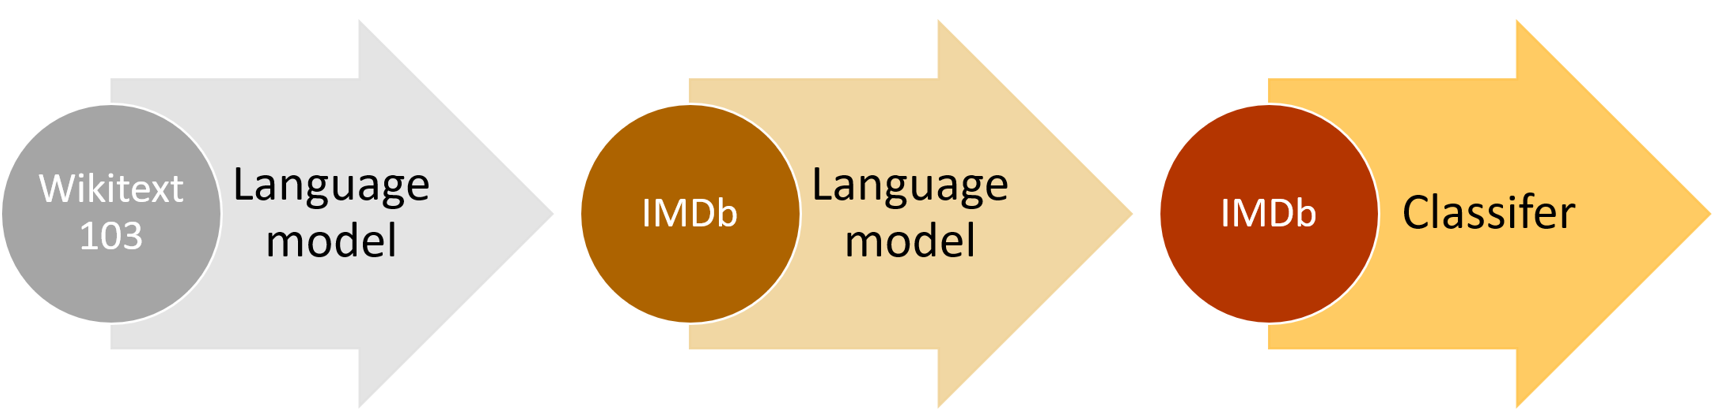
*ULMFit process*

## Fine-tuning a language model on IMDb

We can get our texts in a __[DataLoaders](https://docs.fast.ai/data.core.html#dataloaders)__ suitable for language modeling very easily:

In [ ]:
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid_pct=0.1)

We need to pass something for valid_pct otherwise this method will try to split the data by using the grandparent folder names. By passing valid_pct=0.1, we tell it to get a random 10% of those reviews for the validation set.

We can have a look at our data using __[show_batch](https://docs.fast.ai/vision.gan.html#show_batch)__. Here the task is to guess the next word, so we can see the targets have all shifted one word to the right.

In [ ]:
dls_lm.show_batch(max_n=5)

Then we have a convenience method to directly grab a __[Learner](https://docs.fast.ai/learner.html#learner)__ from it, using the __[AWD_LSTM](https://docs.fast.ai/text.models.awdlstm.html#awd_lstm)__ architecture like before. We use accuracy and perplexity as metrics (the later is the exponential of the loss) and we set a default weight decay of 0.1. to_fp16 puts the __[Learner](https://docs.fast.ai/learner.html#learner)__ in mixed precision, which is going to help speed up training on GPUs that have Tensor Cores.

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

By default, a pretrained __[Learner](https://docs.fast.ai/learner.html#learner)__ is in a frozen state, meaning that only the head of the model will train while the body stays frozen. We show you what is behind the fine_tune method here and use a fit_one_cycle method to fit the model:

In [ ]:
learn.fit_one_cycle(1, 1e-2)

This model takes a while to train, so it’s a good opportunity to talk about saving intermediary results.

You can easily save the state of your model like so:

In [ ]:
learn.save('1epoch')

It will create a file in learn.path/models/ named “1epoch.pth”. If you want to load your model on another machine after creating your __[Learner](https://docs.fast.ai/learner.html#learner)__ the same way, or resume training later, you can load the content of this file with:

In [ ]:
learn = learn.load('1epoch')

We can them fine-tune the model after unfreezing:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the encoder. We can save it with save_encoder:

In [ ]:
learn.save_encoder('finetuned')

*Jargon: Encoder: The model not including the task-specific final layer(s). It means much the same thing as body when applied to vision CNNs, but tends to be more used for NLP and generative models.*

Before using this to fine-tune a classifier on the reviews, we can use our model to generate random reviews: since it’s trained to guess what the next word of the sentence is, we can use it to write new reviews:

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

## Training a text classifier
We can gather our data for text classification almost exactly like before:



In [ ]:
dls_clas = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', text_vocab=dls_lm.vocab)

The main difference is that we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won’t make any sense. We pass that vocabulary with text_vocab.

Then we can define our text classifier like before:

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)


The difference is that before training it, we load the previous encoder:

In [ ]:
learn = learn.load_encoder('finetuned')

The last step is to train with discriminative learning rates and *gradual unfreezing*. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In just one epoch we get the same result as our training in the first section, not too bad! We can pass -2 to freeze_to to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

Then we can unfreeze a bit more, and continue training:

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

And finally, the whole model!

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))